In [1]:
##load all libraries
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import geopandas as gfd 
import xarray as xr
from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client

# used to sign items from the MPC STAC catalog
import planetary_computer

# ----- other libraries for nice ouputs
from IPython.display import Image


In [2]:
## GET THE acess for the server
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)


In [3]:
# Get the collections 
catalog.get_collections()

# get collections and print their names
collections = list(catalog.get_collections())
collections[:5]

[<CollectionClient id=daymet-annual-pr>,
 <CollectionClient id=daymet-daily-hi>,
 <CollectionClient id=3dep-seamless>,
 <CollectionClient id=3dep-lidar-dsm>,
 <CollectionClient id=fia>]

In [4]:
##filter only the required data from the collection
biodiversity = catalog.get_child('io-biodiversity')

In [5]:
# Temporal range of interest
time_range_1 = "2017"
time_range_2 = "2020"

bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# catalog search
search = catalog.search(
    collections=['io-biodiversity'],
    bbox=bbox,
    datetime=time_range_1)

In [6]:
items = search.item_collection()
items

id: bii_2017_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2017-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2017-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


In [7]:
# get first item in the catalog search
item = items[0]
type(item)

pystac.item.Item

In [8]:
# print item id and properties
print('id:' , item.id)
item.properties

id: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

In [9]:
# plot rendered preview
Image(url=item.assets['rendered_preview'].href, width=500)

In [10]:
for key in item.assets.keys():
    print(key, "--", item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [11]:
##
array_raster = rioxr.open_rasterio(item.assets['data'].href)
array_raster

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
## read the shapefile for the arizona and filter only Phoenix 
phoenix = gpd.read_file("data/tl_2022_04_cousub.shp")
phoenix = phoenix[phoenix['NAME']== "Phoenix"]

<Axes: >

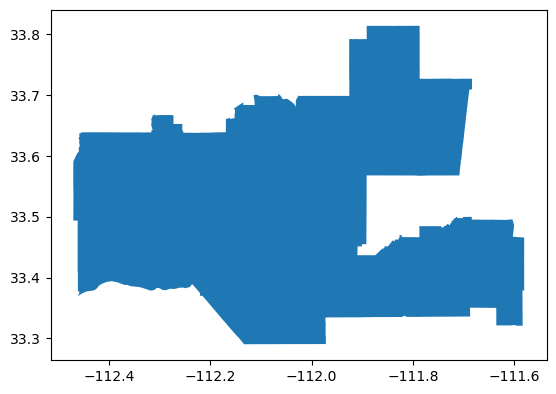

In [13]:
phoenix.plot()

In [14]:
# match the CRS 
print(array_raster.rio.crs == phoenix.crs)

# conver the crs
phoenix = phoenix.to_crs(array_raster.rio.crs)

False


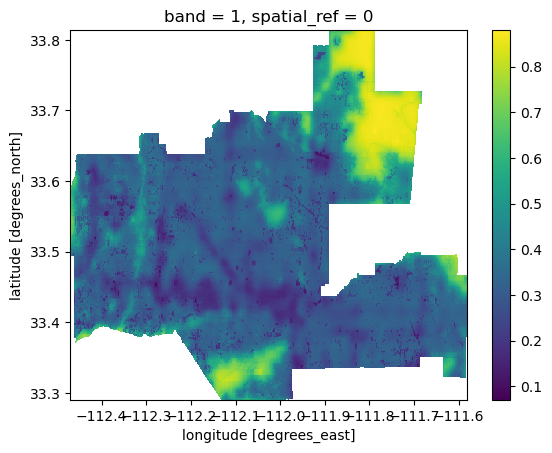

In [15]:
## clip the data to phoenix
clipped_phoenix = array_raster.rio.clip(phoenix.geometry)
clipped_phoenix.plot()

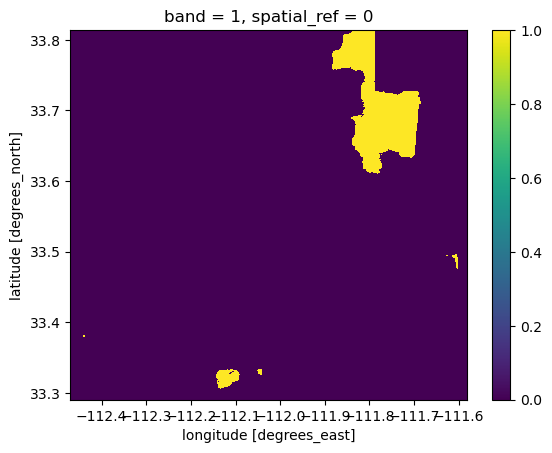

In [16]:
## for areas where BII is greater than 0.75
seven_clipped_phoenix = clipped_phoenix > 0.75
seven_clipped_phoenix.plot()

In [17]:
## calcuate the percentage of area
percentage = seven_clipped_phoenix.sum()/clipped_phoenix.size * 100
print(percentage)

<xarray.DataArray ()>
array(4.18126375)
Coordinates:
    spatial_ref  int64 0


In [18]:
#repeat the same process for another year, rather 
#create a function and organize it for any years to be an input

def process_data(time_range_1):
    bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

    # catalog search
    search = catalog.search(
        collections=['io-biodiversity'],
        bbox=bbox,
        datetime= time_range_1
    )
    
    items = search.item_collection()
    item = items[0]
    
   #convert it to raster array
    array_raster = rioxr.open_rasterio(item.assets['data'].href)

    ## raster the data 
    phoenix = gpd.read_file("data/tl_2022_04_cousub.shp")
    phoenix = phoenix[phoenix['NAME'] == "Phoenix"]

    # convert the crs
    phoenix = phoenix.to_crs(array_raster.rio.crs)

    # clip the data to phoenix
    clipped_phoenix = array_raster.rio.clip(phoenix.geometry)

    # for areas where BII is greater than 0.75
    seven_clipped_phoenix_2 = clipped_phoenix > 0.75
  

    # calculate the percentage of area
    percentage = float(seven_clipped_phoenix_2.sum() / clipped_phoenix.size * 100)
    return seven_clipped_phoenix_2, percentage

# Example usage
time_range_1 = "2017"
time_range_2 = "2020"

## use function to calculate percentage for each time-interval and store it
year_2017 = process_data(time_range_1)
year_2020 = process_data(time_range_2)

In [19]:
# Difference in Data percetage
difference = year_2020[1] - year_2017[1]
print(difference)

-0.3719874560354839


In [20]:
# store the array
BII_index_2020 = year_2020[0]
BII_index_2017 = year_2017[0]

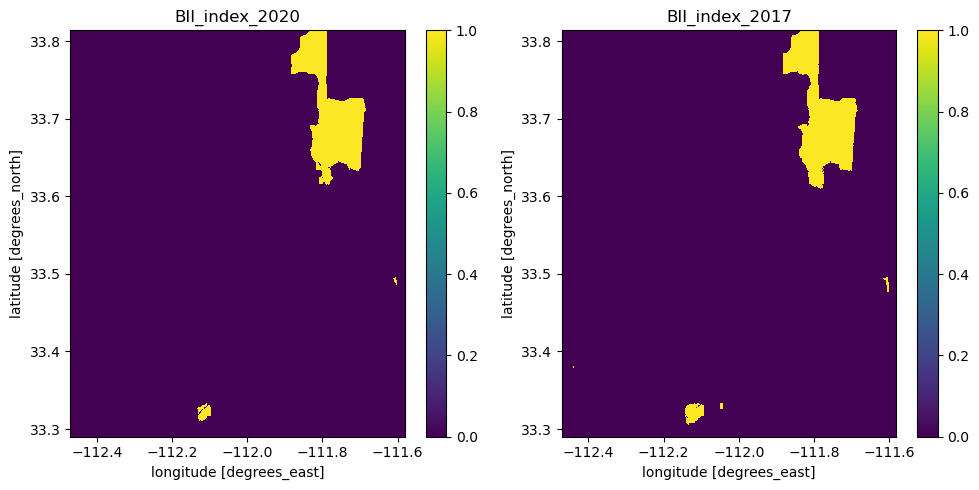

In [21]:
#final part of the questions
# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot BII_index_2020 on the left subplot
BII_index_2020.plot(ax=axs[0], label='BII_index_2020')
axs[0].set_title('BII_index_2020')

# Plot BII_index_2017 on the right subplot
BII_index_2017.plot(ax=axs[1], label='BII_index_2017')
axs[1].set_title('BII_index_2017')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

The side by side plots in the above line does not provide any visual intuition of changes except for some places.
The next part plots the difference in between 2017 and 2018.

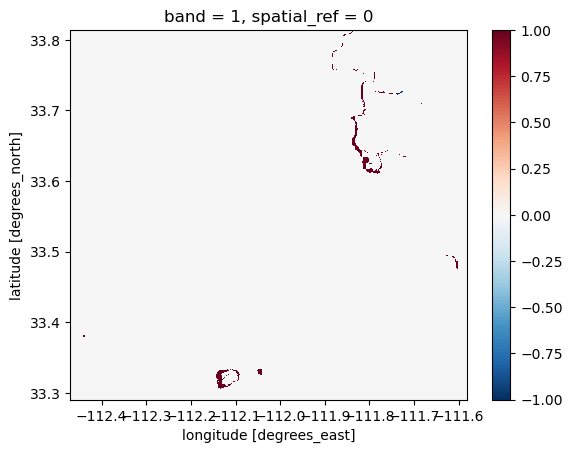

In [22]:
## create a funciton
changed_area = BII_index_2017[0].astype(int) - BII_index_2020[0].astype(int)
changed_area.plot()


In [ ]:
## reclassify the matrix 
changed_area_nan = changed_area.astype(float)

#ch = xr.apply_ufunc(np.digitize, changed_area, classification)
for i in range(changed_area_nan.shape[0]):  # Loop over rows
    for j in range(changed_area_nan.shape[1]):  # Loop over columns
        if changed_area_nan[i, j].item() == 0:
            changed_area_nan[i, j] = np.nan
        elif changed_area_nan[i,j].item() < 0:
            changed_area_nan[i,j] == -1
        else:
            changed_area_nan[i, j] = 1

In [ ]:
# changed_area and look at unique values in the raster
np.unique(changed_area_nan)

In [ ]:
# Assuming changed_area is a NumPy array or a Pandas Series
from rasterio.plot import show
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

colors = ['white', 'red']
class_bins = [-100, 0, 100]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, len(colors))

fig, ax = plt.subplots()
clipped_phoenix.plot(ax=ax, label='Clipped Phoenix')
changed_area_nan.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
decreased_area_patch = mpatches.Patch(color='red', label='BII > 0.75 changed between 2017-2020')
ax.set_axis_off()
ax.set_title('')
ax.legend(handles=[decreased_area_patch], frameon=False, loc='lower center', bbox_to_anchor=(-0.1, 0.8 , 0.5, 0.5))
plt.show()
